**Import Modules**

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import nltk
import tweepy
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import spacy
nlp = spacy.load('en_core_web_lg')
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
import os
os.chdir('F:/Use Cases ML/SMA')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Importing twitter API credentials**

In [2]:
%run ./keys_tweeter.ipynb
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [3]:
search_terms = 'spinal muscular atrophy '
#search_words = ["spinal muscular atrophy", "SMA", "#spinal muscular atrophy"]
lang = 'english'
#date_since = "2021-02-01"
#date_until = "2021-05-12"
tweets = []
likes = []
time = []
#cursor = tweepy.Cursor(api.search,q=search_terms,tweet_mode = "extended",since='2021-01-01', until='2021-05-10').items()
for i in tweepy.Cursor(api.search,q=search_terms,lang="en",tweet_mode = "extended").items(20000):
    tweets.append(i.full_text)
    likes.append(i.favorite_count)
    time.append(i.created_at)

In [4]:
df = pd.DataFrame({'tweets':tweets,'likes':likes,'time':time})

In [5]:
df = df.drop_duplicates(keep=False)
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time  
0 2021-05-12 06:27:19  
1 2021-05-12 06:20:06  
2 2021-05-12 06:17:01  
3 2021-05-12 04:32:59  
4 2021-05-12 04:32:14

**Preprocessing the dataset**

In [6]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [7]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweets'], "@[\w]*")

In [8]:
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  
0 2021-05-12 06:27:19   Plzz spread our crowd funding Link \nhttps://...  
1 2021-05-12 06:20:06  RT : Rupal Gupta wants to raise funds for her ...  
2 2021-05-12 06:17:01  ✍ Rachel shares her experience living with Spi...  
3 2021-05-12 04:32:59  RT :  Happy birthday ma’am. Please help save  ...  
4 2021-05-12 04:32:14  RT : Rupal's son is battling spinal muscular a...

In [9]:
# remove special characters, numbers and punctuations
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  
0 2021-05-12 06:27:19   Plzz spread our crowd funding Link  https   t...  
1 2021-05-12 06:20:06  RT   Rupal Gupta wants to raise funds for her ...  
2 2021-05-12 06:17:01    Rachel shares her experience living with Spi...  
3 2021-05-12 04:32:59  RT    Happy birthday ma am  Please help save  ...  
4 2021-05-12 04:32:14  RT   Rupal s son is battling spinal muscular a...

In [10]:
# remove short words
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  
0 2021-05-12 06:27:19  Plzz spread crowd funding Link https zswRhw sa...  
1 2021-05-12 06:20:06  Rupal Gupta wants raise funds Ayaansh Gupta be...  
2 2021-05-12 06:17:01  Rachel shares experience living with Spinal Mu...  
3 2021-05-12 04:32:59  Happy birthday Please help save special battli...  
4 2021-05-12 04:32:14  Rupal battling spinal muscular atrophy cant ac...

In [11]:
# individual words considered as tokens
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Plzz, spread, crowd, funding, Link, https, zs...
1    [Rupal, Gupta, wants, raise, funds, Ayaansh, G...
2    [Rachel, shares, experience, living, with, Spi...
3    [Happy, birthday, Please, help, save, special,...
4    [Rupal, battling, spinal, muscular, atrophy, c...
Name: clean_tweet, dtype: object

In [12]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [plzz, spread, crowd, fund, link, http, zswrhw...
1    [rupal, gupta, want, rais, fund, ayaansh, gupt...
2    [rachel, share, experi, live, with, spinal, mu...
3    [happi, birthday, pleas, help, save, special, ...
4    [rupal, battl, spinal, muscular, atrophi, cant...
Name: clean_tweet, dtype: object

In [13]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean_tweet'] = tokenized_tweet
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  
0 2021-05-12 06:27:19  plzz spread crowd fund link http zswrhw save m...  
1 2021-05-12 06:20:06  rupal gupta want rais fund ayaansh gupta been ...  
2 2021-05-12 06:17:01  rachel share experi live with spinal muscular ...  
3 2021-05-12 04:32:59  happi birthday pleas help save special battl l...  
4 2021-05-12 04:32:14  rupal battl spinal muscular atrophi cant activ...

**Exploratory Data Analysis**

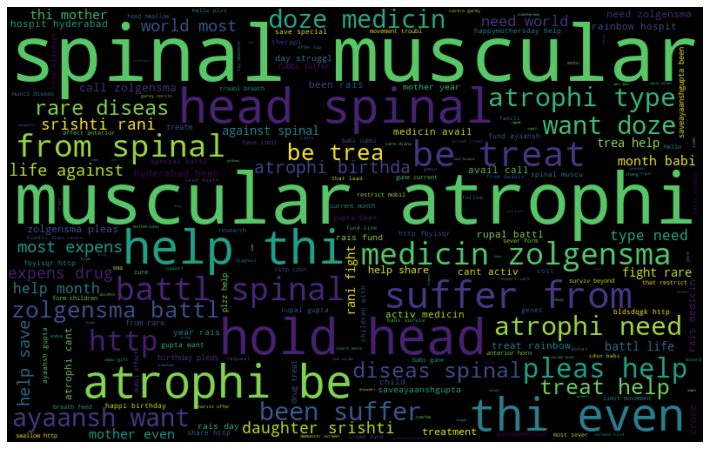

In [14]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_tweet']])
from sklearn.feature_extraction import text
add_stop_words = ['https', 'get', 'many', 'have', 'hold', 'sir','need','help','plz','make','available','pls','from']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42,max_font_size=100,stopwords=stop_words).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
import nltk
#vador lexicon approach
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [17]:
df['clean_tweet_score'] = df['clean_tweet'].apply(lambda review: sia.polarity_scores(review))

In [18]:
df['sentiment_clean_tweet_score'] = df['clean_tweet_score'].apply(lambda x:x['compound'])

In [19]:
df['compound_score'] = df['sentiment_clean_tweet_score'].apply(lambda score: 'pos' if score > 0 else 'neg')

In [20]:
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  \
0 2021-05-12 06:27:19  plzz spread crowd fund link http zswrhw save m...   
1 2021-05-12 06:20:06  rupal gupta want rais fund ayaansh gupta been ...   
2 2021-05-12 06:17:01  rachel share experi live with spinal muscular ...   
3 2021-05-12 04:32:59  happi birthday pleas help save special battl l...   
4 2021-05-12 04:32:14  rupal battl spinal muscular atrophi cant activ...   

                                   clean_tweet_score  \
0  {'neg': 0.182, 'neu': 0.739, 'pos': 0.079, 'co...   
1  {'neg': 0.208, 'neu': 0.714, 'pos': 0.077, 'co...   
2  {'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...   
3  {'neg': 0.0, 'neu': 0.482, 'pos': 0.518, 'comp...   
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

   sentiment_clean_tweet_score compound_score  
0                      -0.6369            neg  
1                      -0.4939            neg  
2                       0.2960            pos  
3                       0.8225            pos  
4                       0.0000            neg

In [21]:
#Intution about the percentage of male / female survival rate
def bar_chart(feature):
    positive = df[df['compound_score'] == 'pos'][feature].value_counts()
    negative = df[df['compound_score'] == 'neg'][feature].value_counts()
    df1 = pd.DataFrame([positive,negative])
    df1.index = ['positive','negative']
    df1.plot(kind = 'bar',stacked = True,figsize=(10,5))

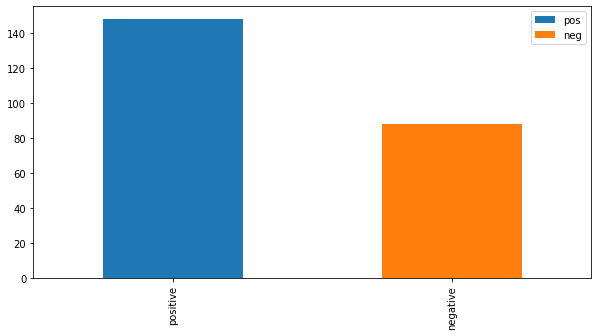

In [22]:
bar_chart('compound_score')

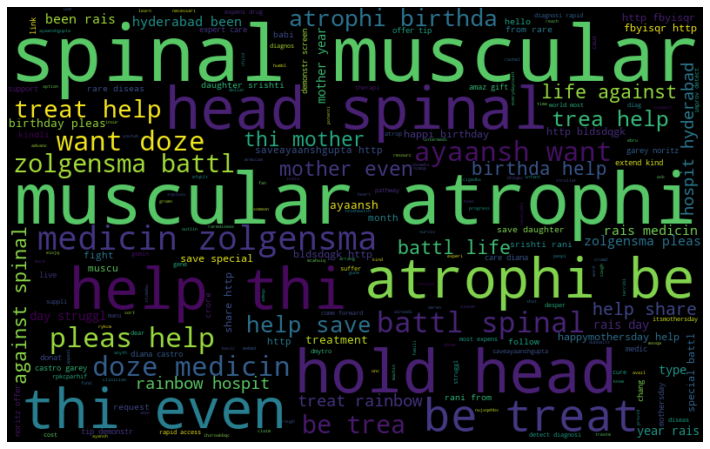

In [23]:
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['compound_score']=='pos']])
add_stop_words = ['https', 'get', 'many', 'have', 'hold', 'sir','need','help','plz','make','available','pls','from']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100,stopwords=stop_words).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

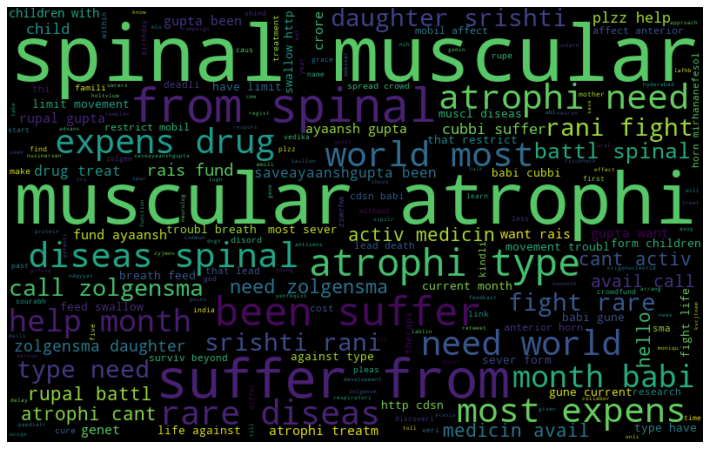

In [24]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['compound_score']=='neg']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
# extract the hashtag
# def hashtag_extract(tweets):
#     hashtags = []
#     # loop words in the tweet
#     for tweet in tweets:
#         ht = re.findall(r"#(\w+)", tweet)
#         hashtags.append(ht)
#     return hashtags

In [26]:
# extract hashtags from non-racist/sexist tweets
# ht_positive = hashtag_extract(df['clean_tweet'][df['compound_score']=='pos'])

# # extract hashtags from racist/sexist tweets
# ht_negative = hashtag_extract(df['clean_tweet'][df['compound_score']=='neg'])

In [27]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['tweets'].apply(pol)
df['subjectivity'] = df['tweets'].apply(sub)
df.head()

tweets  likes  \
0  @ravikishann Plzz spread our crowd funding Lin...      0   
1  RT @shalabh2130: Rupal Gupta wants to raise fu...      0   
2  ✍ Rachel shares her experience living with Spi...      0   
3  RT @Ntripathi1990: @chitraaum Happy birthday m...      0   
4  RT @shishirmba: Rupal's son is battling spinal...      0   

                 time                                        clean_tweet  \
0 2021-05-12 06:27:19  plzz spread crowd fund link http zswrhw save m...   
1 2021-05-12 06:20:06  rupal gupta want rais fund ayaansh gupta been ...   
2 2021-05-12 06:17:01  rachel share experi live with spinal muscular ...   
3 2021-05-12 04:32:59  happi birthday pleas help save special battl l...   
4 2021-05-12 04:32:14  rupal battl spinal muscular atrophi cant activ...   

                                   clean_tweet_score  \
0  {'neg': 0.182, 'neu': 0.739, 'pos': 0.079, 'co...   
1  {'neg': 0.208, 'neu': 0.714, 'pos': 0.077, 'co...   
2  {'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp...   
3  {'neg': 0.0, 'neu': 0.482, 'pos': 0.518, 'comp...   
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

   sentiment_clean_tweet_score compound_score  polarity  subjectivity  
0                      -0.6369            neg  0.166667      0.533333  
1                      -0.4939            neg  0.200000      0.100000  
2                       0.2960            pos  0.000000      0.500000  
3                       0.8225            pos  0.578571      0.785714  
4                       0.0000            neg  0.400000      0.400000

**Model building**

In [28]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [29]:
label_map = {'pos':0,'neg':1,}
df['label'] = df['compound_score'].map(label_map)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

**Model Training**

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [32]:
# training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [33]:
# testing
pred = model.predict(x_test)
f1_score(y_test, pred)

0.9600000000000001

In [34]:
accuracy_score(y_test,pred)

0.9661016949152542

In [35]:
# use probability to get output
pred_prob = model.predict_proba(x_test)
pred = pred_prob[:, 1] >= 0.3
pred = pred.astype(np.int)

f1_score(y_test, pred)

0.9600000000000001

In [36]:
accuracy_score(y_test,pred)

0.9661016949152542